In [5]:
%pip install folium



   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   -------- -------------------------------  2/10 [MarkupSafe]
   ------------ ---------------------------  3/10 [idna]
   ---------------- -----------------------  4/10 [charset-normalizer]
   ---------------- -----------------------  4/10 [charset-normalizer]
   ---------------- -----------------------  4/10 [charset-normalizer]
   -------------------- -------------------  5/10 [certifi]
   ------------------------ ---------------  6/10 [requests]
   ------------------------ ---------------  6/10 [requests]
   ---------------------------- -----------  7/10 [jinja2]
   ---------------------------- -----------  7/10 [jinja2]
   ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


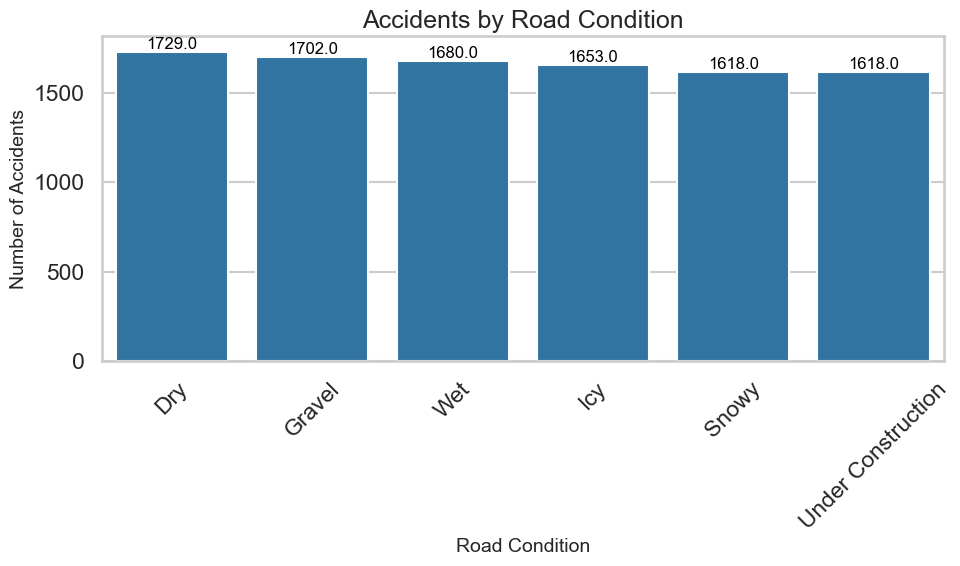

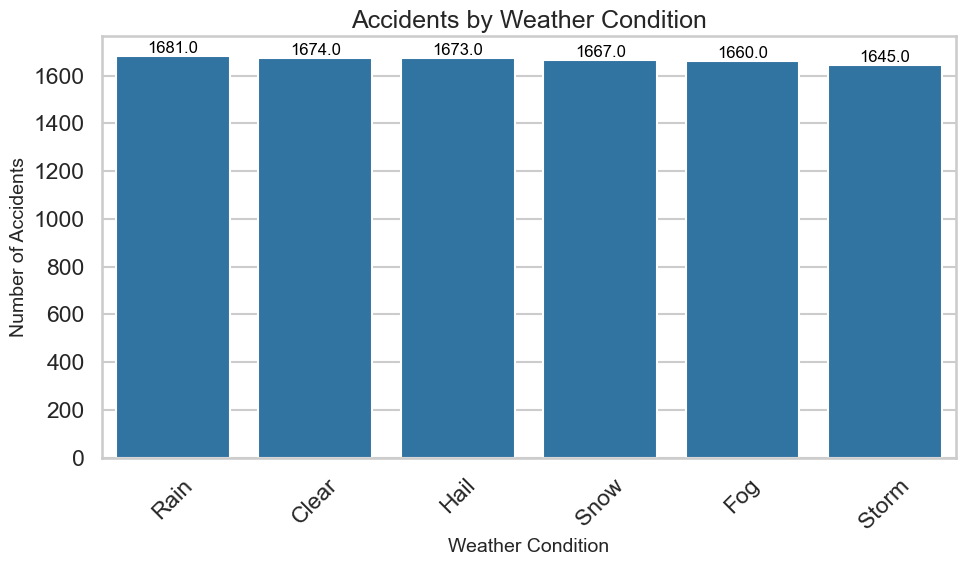

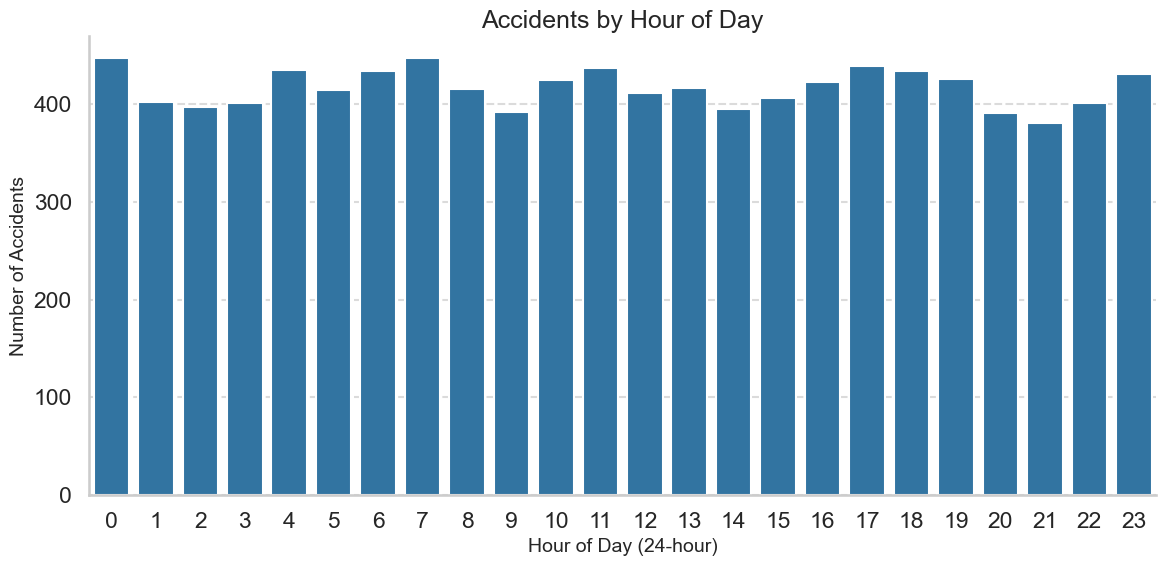

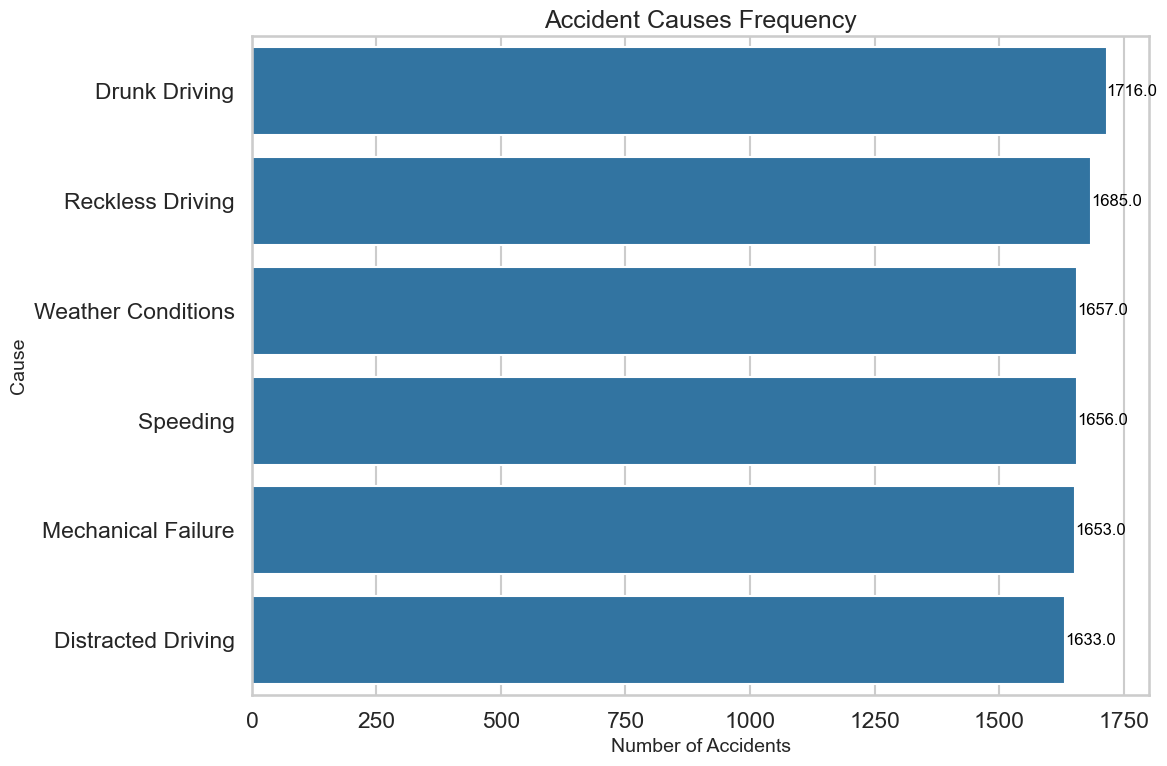

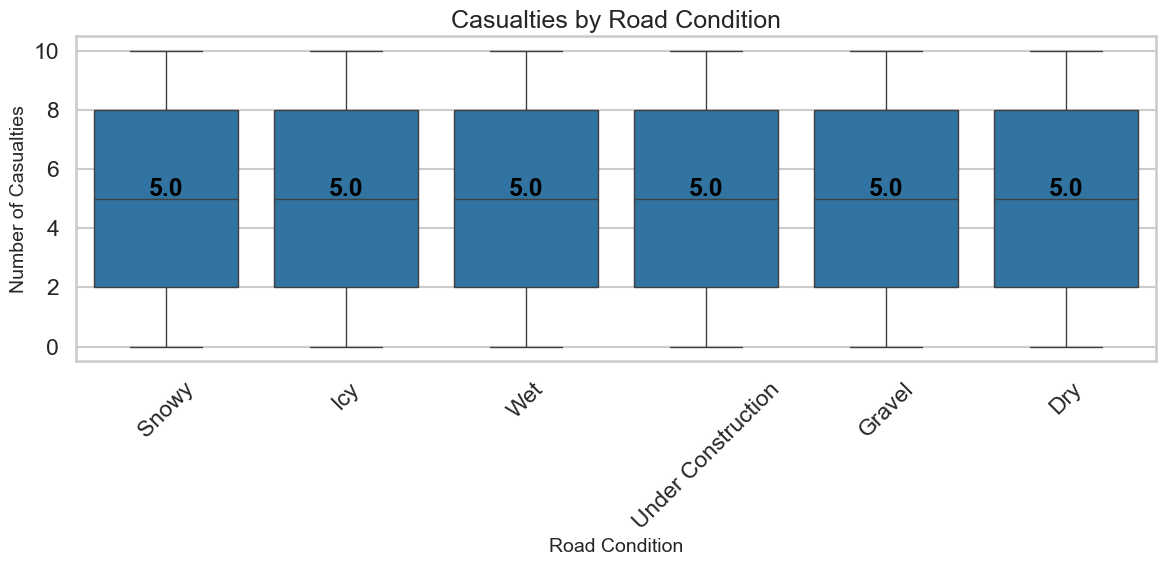

Accident hotspots map saved as 'accident_hotspots.html'. Open it in a browser to explore.
  Accident ID       Date      Time           Location   Latitude   Longitude  \
0    b0dd6f57 2023-04-19  06:39:00      Mumbai, India  13.488432  -73.290682   
1    debfad09 2023-01-17  02:47:00   So Paulo, Brazil -37.798317  -32.244242   
2    6d69aa36 2024-04-09  02:55:00  Sydney, Australia  33.767869  104.869018   
3    425bb1f0 2023-10-10  11:23:00       Tokyo, Japan  -0.378031 -165.825855   
4    90d5cf62 2023-01-02  12:07:00     Beijing, China  41.254879  -30.776959   

  Weather Condition Road Condition  Vehicles Involved  Casualties  \
0              Snow          Snowy                  5           7   
1             Clear            Icy                  4           1   
2              Rain          Snowy                  1           7   
3             Storm            Wet                  4           0   
4             Storm          Snowy                  3           9   

              

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# --- 1. Load Dataset ---
df = pd.read_csv('task5.csv')

# --- 2. Data Cleaning ---
df['Location'] = df['Location'].astype(str).str.encode('latin1').str.decode('utf-8', errors='ignore')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.time

df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
df['Hour'] = df['DateTime'].dt.hour

df = df.dropna(subset=['Latitude', 'Longitude'])
df = df[(df['Latitude'] >= -90) & (df['Latitude'] <= 90)]
df = df[(df['Longitude'] >= -180) & (df['Longitude'] <= 180)]

# --- Set seaborn style ---
sns.set_style("whitegrid")
sns.set_context("talk")

# --- 3. Visualizations ---

# Accidents by Road Condition
plt.figure(figsize=(10,6))
road_order = df['Road Condition'].value_counts().index
ax = sns.countplot(data=df, x='Road Condition', order=road_order)
plt.title('Accidents by Road Condition', fontsize=18)
plt.xlabel('Road Condition', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=45)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width()/2, height), 
                ha='center', va='bottom', fontsize=12, color='black')
plt.tight_layout()
plt.show()

# Accidents by Weather Condition
plt.figure(figsize=(10,6))
weather_order = df['Weather Condition'].value_counts().index
ax = sns.countplot(data=df, x='Weather Condition', order=weather_order)
plt.title('Accidents by Weather Condition', fontsize=18)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
plt.xticks(rotation=45)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width()/2, height), 
                ha='center', va='bottom', fontsize=12, color='black')
plt.tight_layout()
plt.show()

# Accidents by Hour of Day
plt.figure(figsize=(12,6))
hour_order = range(0,24)
ax = sns.countplot(data=df, x='Hour', order=hour_order)
plt.title('Accidents by Hour of Day', fontsize=18)
plt.xlabel('Hour of Day (24-hour)', fontsize=14)
plt.ylabel('Number of Accidents', fontsize=14)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Accident Causes Frequency (horizontal bar plot)
plt.figure(figsize=(12,8))
cause_order = df['Cause'].value_counts().index
ax = sns.countplot(data=df, y='Cause', order=cause_order)
plt.title('Accident Causes Frequency', fontsize=18)
plt.xlabel('Number of Accidents', fontsize=14)
plt.ylabel('Cause', fontsize=14)
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width}', (width, p.get_y() + p.get_height()/2), 
                ha='left', va='center', fontsize=12, color='black')
plt.tight_layout()
plt.show()

# Casualties by Road Condition (boxplot)
plt.figure(figsize=(12,6))
ax = sns.boxplot(data=df, x='Road Condition', y='Casualties')
plt.title('Casualties by Road Condition', fontsize=18)
plt.xlabel('Road Condition', fontsize=14)
plt.ylabel('Number of Casualties', fontsize=14)
plt.xticks(rotation=45)

medians = df.groupby('Road Condition')['Casualties'].median().reindex(road_order)
for xtick in range(len(road_order)):
    plt.text(xtick, medians[road_order[xtick]] + 0.1, f'{medians[road_order[xtick]]:.1f}', 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

# --- 4. Accident Hotspots Map ---
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
accident_map = folium.Map(location=map_center, zoom_start=5)

heat_data = df[['Latitude', 'Longitude']].values.tolist()
HeatMap(heat_data).add_to(accident_map)

# Optional: Add circle markers with popup info
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        popup=(f"Location: {row['Location']}<br>"
               f"DateTime: {row['DateTime']}<br>"
               f"Casualties: {row['Casualties']}<br>"
               f"Cause: {row['Cause']}"),
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(accident_map)

accident_map.save('accident_hotspots.html')
print("Accident hotspots map saved as 'accident_hotspots.html'. Open it in a browser to explore.")

# --- 5. Show sample data ---
print(df.head())
